In [1]:
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
from torch. optim.lr_scheduler import ExponentialLR
from tqdm import tqdm
import pickle
import random
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

In [2]:
cuda = 'cuda:1'

In [3]:
class ImageDataset(Dataset):

    def __init__(self, data, transform=None):
        self.data = data
        self.l = len(self.data)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)

        return sample

In [4]:
file = open('C:/VSCode/VAE/Faces_VAE/train_dataset_small.pkl', 'rb')
train_dataset = pickle.load(file)
file.close()
file = open('C:/VSCode/VAE/Faces_VAE/test_dataset_small.pkl', 'rb')
test_dataset = pickle.load(file)
file.close()

In [5]:
train_batch_size = 400
test_batch_size = 200
train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=False)

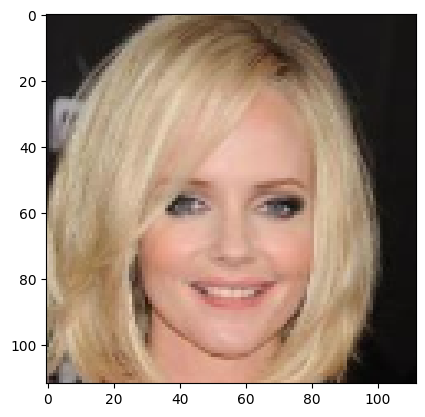

In [6]:
image = next(iter(train_loader))
plt.imshow(image[0].permute(1,2,0))
plt.show()

In [7]:
resnet = models.resnet18(weights='DEFAULT')
resnet_half = torch.nn.Sequential(*(list(resnet.children())[:7]))

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.latent_size = 12544
        self.encoder = nn.Sequential(
            *(list(resnet_half.children())),
            nn.ReLU(),
            nn.Flatten()
        )
        self.mu = nn.Sequential(
            nn.Linear(12544, self.latent_size)
        )
        self.log_var = nn.Sequential(
            nn.Linear(12544, self.latent_size),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, torch.Size([256, 7, 7])),
            nn.ConvTranspose2d(256, 256, (3,3),(2,2), padding=1),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, (3,3),(1,1), padding=1),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, (3,3),(2,2)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, (3,3),(1,1), padding=1),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, (3,3),(2,2)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, (3,3),(1,1), padding=1),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, (3,3),(1,1), padding=1),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, (3,3),(2,2)),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, (3,3),(1,1), padding=1),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, (4,4),(1,1), padding=1),
            nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Sigmoid()
        )
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        x = self.reparameterize(mu, log_var)
        x = self.decoder(x)
        return x, mu, log_var

In [9]:
model = Net()
#model = nn.DataParallel(model, device_ids=[1,0])
model.to(cuda)

Net(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [10]:
def loss_f(output, target, mu, log_var):
    MSE = nn.MSELoss(reduction='mean')(output, target)
    KLD = 0.5 * torch.mean(mu**2 + torch.exp(log_var) -1 - log_var)
    return MSE + KLD, MSE, KLD

In [11]:
optimizer = optim.Adam(model.parameters(), lr = 0.00000067)
scheduler = ExponentialLR(optimizer, gamma=0.99)

train_loss_list = []
test_loss_list = []
train_MSE_list = []
test_MSE_list = []
train_KLD_list = []
test_KLD_list = []

for epoch in tqdm(range(200)):
    optimizer.zero_grad()
    for x_train in train_loader:
        x_train = x_train.to(cuda)
        outputs, mu, log_var = model(x_train)
        loss, MSE, KLD = loss_f(outputs, x_train, mu, log_var)
        loss.backward()
        optimizer.step()
    scheduler.step()
    if (epoch + 1) % 10 == 0:
        for x_test in test_loader:
            x_test = x_test.to(cuda)
            outputs, mu, log_var = model(x_test)
            test_loss, test_MSE, test_KLD = loss_f(outputs, x_test, mu, log_var)
        print("Epoch:", epoch + 1, "Train_Loss:", loss.item(), "Test_Loss:", test_loss.item(), "Learning_Rate:", scheduler.optimizer.param_groups[0]['lr'])
        print("Train_MSE:", MSE.item(), "Train_KLD:", KLD.item(), "Test_MSE:", test_MSE.item(), "Test_KLD:", test_KLD.item())

        train_loss_list.append(loss.item())
        test_loss_list.append(test_loss.item())
        train_MSE_list.append(MSE.item())
        test_MSE_list.append(test_MSE.item())
        train_KLD_list.append(KLD.item())
        test_KLD_list.append(test_KLD.item())

  5%|▌         | 10/200 [22:20<7:05:44, 134.44s/it]

Epoch: 10 Train_Loss: 0.06364922225475311 Test_Loss: 0.065617635846138 Learning_Rate: 6.05935990255899e-07
Train_MSE: 0.05435960367321968 Train_KLD: 0.009289615787565708 Test_MSE: 0.05644628405570984 Test_KLD: 0.00917135365307331


 10%|█         | 20/200 [44:39<6:43:04, 134.36s/it]

Epoch: 20 Train_Loss: 0.05295911431312561 Test_Loss: 0.05068062245845795 Learning_Rate: 5.479976481901447e-07
Train_MSE: 0.04547448456287384 Train_KLD: 0.00748462975025177 Test_MSE: 0.04316132143139839 Test_KLD: 0.0075193000957369804


 15%|█▌        | 30/200 [1:06:57<6:20:27, 134.28s/it]

Epoch: 30 Train_Loss: 0.04656912386417389 Test_Loss: 0.04630420356988907 Learning_Rate: 4.95599250170148e-07
Train_MSE: 0.03991271182894707 Train_KLD: 0.00665641063824296 Test_MSE: 0.03938395157456398 Test_KLD: 0.006920252926647663


 20%|██        | 40/200 [1:29:16<5:58:50, 134.57s/it]

Epoch: 40 Train_Loss: 0.042000312358140945 Test_Loss: 0.0439874604344368 Learning_Rate: 4.48211078241686e-07
Train_MSE: 0.034989237785339355 Train_KLD: 0.007011075504124165 Test_MSE: 0.03725414723157883 Test_KLD: 0.006733314599841833


 25%|██▌       | 50/200 [1:51:36<5:36:17, 134.52s/it]

Epoch: 50 Train_Loss: 0.04361431300640106 Test_Loss: 0.04202863946557045 Learning_Rate: 4.053540649821495e-07
Train_MSE: 0.03644540160894394 Train_KLD: 0.00716891186311841 Test_MSE: 0.0352943018078804 Test_KLD: 0.006734338589012623


 30%|███       | 60/200 [2:13:57<5:14:04, 134.60s/it]

Epoch: 60 Train_Loss: 0.03975297138094902 Test_Loss: 0.04141515493392944 Learning_Rate: 3.665949504018101e-07
Train_MSE: 0.03290179371833801 Train_KLD: 0.006851176731288433 Test_MSE: 0.03469924256205559 Test_KLD: 0.00671591330319643


 35%|███▌      | 70/200 [2:36:20<4:52:13, 134.87s/it]

Epoch: 70 Train_Loss: 0.0375254862010479 Test_Loss: 0.040727827697992325 Learning_Rate: 3.315419019321387e-07
Train_MSE: 0.031016414985060692 Train_KLD: 0.006509070284664631 Test_MSE: 0.03409796208143234 Test_KLD: 0.006629867013543844


 40%|████      | 80/200 [2:58:41<4:29:18, 134.66s/it]

Epoch: 80 Train_Loss: 0.038164496421813965 Test_Loss: 0.03990834951400757 Learning_Rate: 2.9984055322175313e-07
Train_MSE: 0.031484201550483704 Train_KLD: 0.006680293940007687 Test_MSE: 0.03338172286748886 Test_KLD: 0.0065266285091638565


 42%|████▎     | 85/200 [3:10:25<4:17:38, 134.42s/it]


KeyboardInterrupt: 

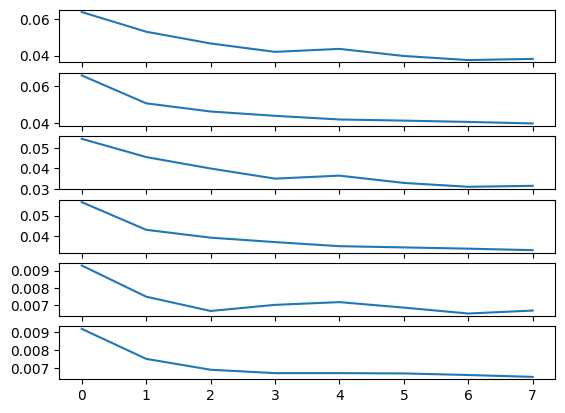

In [12]:
fig, ax = plt.subplots(6)
ax[0].plot(train_loss_list)
ax[1].plot(test_loss_list)
ax[2].plot(train_MSE_list)
ax[3].plot(test_MSE_list)
ax[4].plot(train_KLD_list)
ax[5].plot(test_KLD_list)

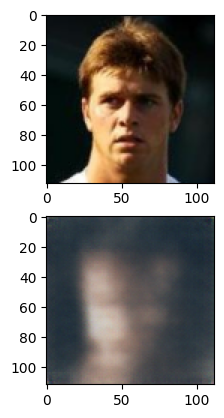

In [15]:
fig, ax = plt.subplots(2)
torch.no_grad()
x_train = next(iter(train_loader))
x_train = x_train.to(cuda)
outputs, mu, log_var = model(x_train)
outputs = outputs.cpu().detach()
ax[0].imshow(x_train.cpu()[0].permute((1,2,0)))
ax[1].imshow(outputs[0].permute(1,2,0)) 

In [ ]:
torch.save(model.state_dict(), 'checkpoint300.pickle')

NameError: name 'torch' is not defined